# Marine Carbonate System Visualizer

## Interactive Bjerrum Plot for Marine Chemistry

This tool visualizes the marine carbonate system using **Bjerrum plots**. 

**Features:**
- Interactive sliders for Total Alkalinity and DIC
- 4-panel visualization showing carbonate speciation
- Real-time calculations using PyCO2SYS
- Educational tool for marine chemistry courses

**Instructions:**
1. Adjust the sliders below to change Total Alkalinity and DIC values
2. Observe how the carbonate system responds in real-time
3. Use the Reset button to return to default values

## What does this tool show?

**Input parameters:**
- **Total alkalinity** (TA) in μmol/kg
- **Dissolved Inorganic Carbon** (DIC) in μmol/kg

**Fixed conditions:**
- **Salinity** = 35 PSU
- **Temperature** = 25°C

**Visualizations:**
1. **Bjerrum Plot** - Species fractions vs pH
2. **Current Composition** - Pie chart of species
3. **Saturation State** - Aragonite saturation
4. **System Analysis** - Detailed results

In [5]:
import PyCO2SYS as pyco2
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, VBox, interactive_output, Button, Layout, HTML
from IPython.display import display, clear_output

def compute_carbonate_system(alkalinity, DIC, salinity=35, temperature=25):
    """Compute carbonate system using PyCO2SYS"""
    results = pyco2.sys(
        par1=alkalinity,      # Total Alkalinity (μmol/kg)
        par2=DIC,             # DIC (μmol/kg)
        par1_type=1,          # 1 = total alkalinity
        par2_type=2,          # 2 = DIC
        salinity=salinity,    # Salinity in PSU
        temperature=temperature  # Temperature in °C
    )

    return {
        "pH_total": results["pH_total"],
        "pCO2": results["pCO2"],
        "bicarbonate": results["bicarbonate"],
        "carbonate": results["carbonate"],
        "omega_aragonite": results["saturation_aragonite"],
        "salinity": salinity,
        "temperature": temperature
    }

In [6]:
def create_bjerrum_plot(data):
    """Create simplified Bjerrum plot"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Marine Carbonate System Analysis', fontsize=16, fontweight='bold')
    
    # Colors
    colors = ['#440154', '#31688e', '#35b779', '#fde725']
    
    # Generate pH range for Bjerrum plot
    pH_range = np.linspace(4, 11, 100)
    
    # Simplified constants for seawater at 25°C, S=35
    K1 = 10**(-6.0)   # First dissociation constant 
    K2 = 10**(-9.3)   # Second dissociation constant 
    
    co2_fractions = []
    hco3_fractions = []
    co3_fractions = []
    
    for pH in pH_range:
        H = 10**(-pH)
        denominator = H**2 + K1*H + K1*K2
        alpha0 = H**2 / denominator  # CO2
        alpha1 = K1*H / denominator  # HCO3-
        alpha2 = K1*K2 / denominator  # CO3-2
        
        co2_fractions.append(alpha0)
        hco3_fractions.append(alpha1)
        co3_fractions.append(alpha2)
    
    # Plot 1: Bjerrum Plot
    ax1.plot(pH_range, co2_fractions, color=colors[0], linewidth=3, label='CO2')
    ax1.plot(pH_range, hco3_fractions, color=colors[1], linewidth=3, label='HCO3-')
    ax1.plot(pH_range, co3_fractions, color=colors[2], linewidth=3, label='CO3-2')
    
    current_pH = data['pH_total']
    ax1.axvline(x=current_pH, color='red', linestyle='--', linewidth=2)
    ax1.text(current_pH + 0.1, 0.8, f'pH: {current_pH:.2f}', fontsize=10, color='red')
    
    ax1.set_xlabel('pH')
    ax1.set_ylabel('Fraction')
    ax1.set_title('Bjerrum Plot')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(4, 11)
    ax1.set_ylim(0, 1)
    
    # Plot 2: Composition pie chart
    current_co2 = data["pCO2"] * 0.034
    species_values = [current_co2, data["bicarbonate"], data["carbonate"]]
    species_labels = ['CO2', 'HCO3-', 'CO3-2']
    
    ax2.pie(species_values, labels=species_labels, autopct='%1.1f%%', colors=colors[:3])
    ax2.set_title(f'Composition at pH {current_pH:.2f}')
    
    # Plot 3: Saturation state
    omega = data["omega_aragonite"]
    ax3.bar(['Aragonite'], [omega], color=colors[3] if omega >= 1 else colors[0])
    ax3.axhline(y=1, color='black', linestyle='--')
    ax3.set_ylabel('Omega')
    ax3.set_title('Saturation State')
    ax3.text(0, omega*0.7, f'Ω = {omega:.2f}', ha='center', fontsize=12)
    
    # Plot 4: System info
    ax4.axis('off')
    info_text = f"""System Parameters:

Total Alkalinity: {(data['bicarbonate'] + 2*data['carbonate']):.0f} μmol/kg
DIC Total: {data['bicarbonate'] + data['carbonate'] + current_co2:.0f} μmol/kg
Salinity: {data['salinity']} PSU
Temperature: {data['temperature']}°C

Results:
pH: {data['pH_total']:.2f}
pCO2: {data['pCO2']:.0f} μatm
[HCO3-]: {data['bicarbonate']:.0f} μmol/kg
[CO3-2]: {data['carbonate']:.0f} μmol/kg
Ω_aragonite: {data['omega_aragonite']:.2f}"""
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Create sliders
alk_slider = FloatSlider(
    value=2300, 
    min=1800, 
    max=3500, 
    step=25,
    description="Alkalinity (μmol/kg):",
    style={'description_width': 'initial'},
    layout=Layout(width='600px')
)

dic_slider = FloatSlider(
    value=2020, 
    min=1600, 
    max=3500, 
    step=25,
    description="DIC (μmol/kg):",
    style={'description_width': 'initial'},
    layout=Layout(width='600px')
)

# Create output widget
output = VBox()

print("Sliders created successfully!")

Sliders created successfully!


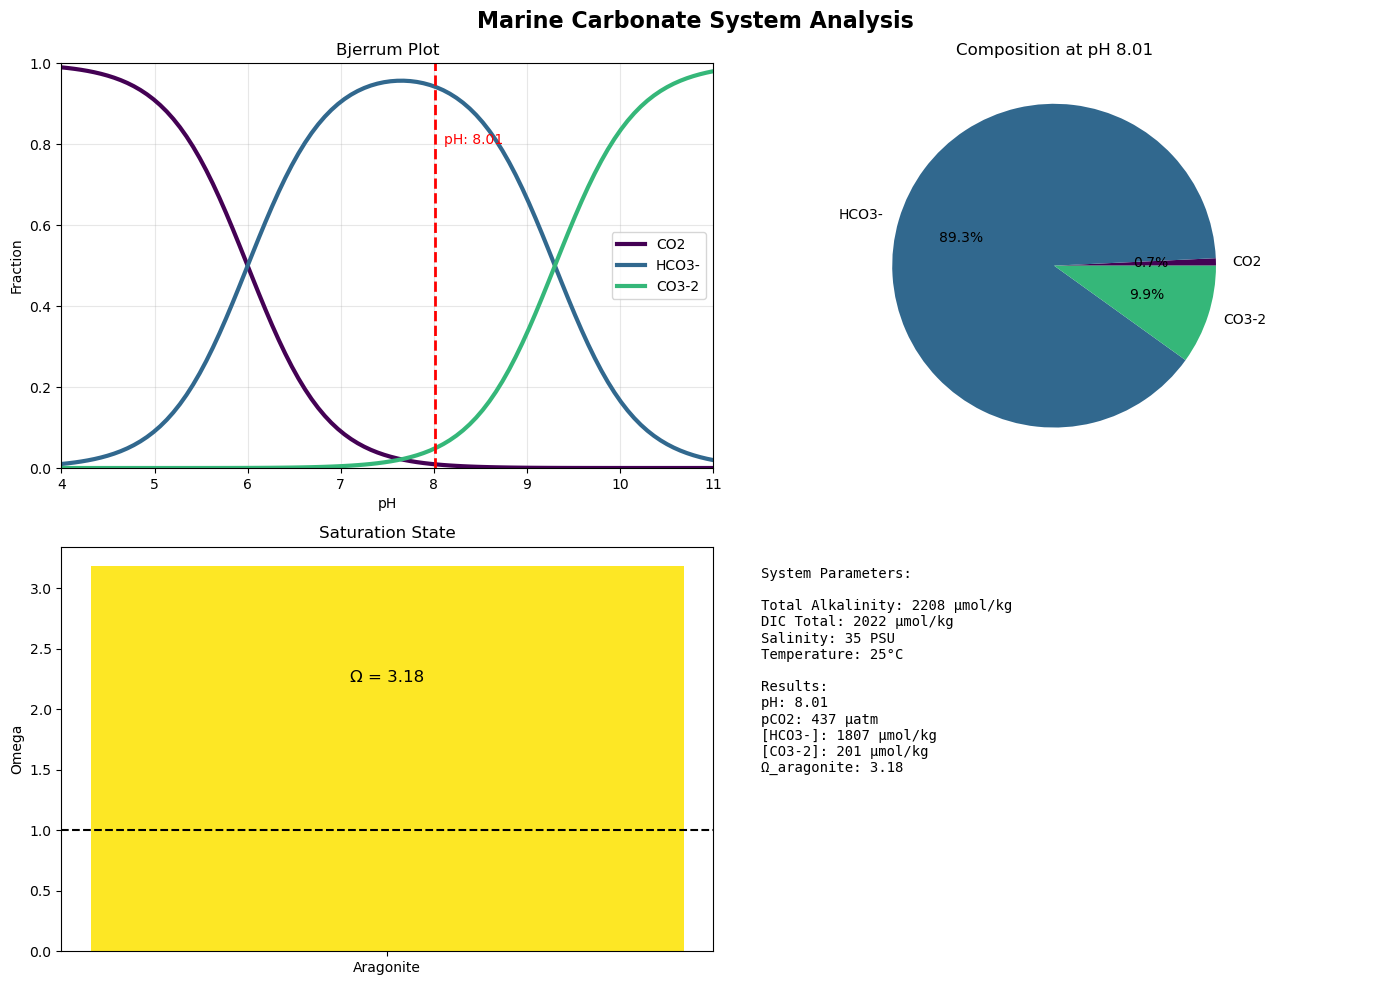

In [8]:
# Create interactive interface
def update_plot(alkalinity, DIC):
    """Update plot when sliders change"""
    data = compute_carbonate_system(alkalinity, DIC)
    create_bjerrum_plot(data)

# Create interactive output
interactive_plot = interactive_output(update_plot, {
    'alkalinity': alk_slider, 
    'DIC': dic_slider
})

# Reset button
reset_button = Button(description="Reset to Default Values")

def reset_values(b):
    alk_slider.value = 2300
    dic_slider.value = 2020

reset_button.on_click(reset_values)

# Display interface
display(VBox([
    HTML("<h3>Adjust parameters to explore the carbonate system:</h3>"),
    alk_slider,
    dic_slider,
    reset_button,
    interactive_plot
]))

# Initial plot
update_plot(alk_slider.value, dic_slider.value)

**Author:** Cardoso-Mohedano JG  
**Institution:** Instituto de Ciencias del Mar y Limnologia, UNAM, Estacion El Carmen  
**License:** [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)  
**ORCID:** [0000-0002-2918-972X](https://orcid.org/0000-0002-2918-972X)

---
This interactive tool allows exploration of the marine carbonate system using [PyCO2SYS](https://pyco2sys.readthedocs.io/en/latest/).  
Developed with support from [Claude AI](https://claude.ai) by Anthropic and [OpenAI ChatGPT](https://openai.com/chatgpt) and educational Python tools.